In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('negative.csv', sep=';', header=None, usecols=[3, 4], names=['text', 'label'])
df.head()

,text,label
0,на работе был полный пиддес :| и так каждое за...,-1
1,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1
2,@elina_4post как говорят обещаного три года жд...,-1
3,"Желаю хорошего полёта и удачной посадки,я буду...",-1
4,"Обновил за каким-то лешим surf, теперь не рабо...",-1


In [3]:
import re
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem

In [5]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [6]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [7]:
df['text'] = df['text'].apply(preprocess)
df.head()

,text,label
0,"[работа, полный, пиддес, каждый, закрытие, мес...",-1
1,"[коллега, сидеть, рубиться, urban, terror, дол...",-1
2,"[говорить, обещаной, год, ждать]",-1
3,"[желать, хороший, полёт, удачный, посадка, оче...",-1
4,"[обновить, леший, surf, работать, простоплеер]",-1


In [8]:
from gensim.models import *
from gensim import corpora

In [9]:
dictionary = corpora.Dictionary(df['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('tweet.dict')

In [10]:
corpus = [dictionary.doc2bow(text) for text in df['text']]
corpora.MmCorpus.serialize('tweet.model', corpus) 

In [11]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: total: 2min 47s
Wall time: 4min 4s


In [12]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(1,
  '0.404*"мочь" + 0.138*"сидеть" + 0.102*"неделя" + 0.085*"вчера" + 0.054*"работать" + 0.053*"плакать" + 0.034*"больница" + 0.029*"лежать" + 0.027*"тви" + 0.015*"заходить"'),
 (12,
  '0.000*"игнорить" + 0.000*"барановский" + 0.000*"светить" + 0.000*"поштый" + 0.000*"обратный" + 0.000*"гадать" + 0.000*"эгоист" + 0.000*"мошенник" + 0.000*"викторович" + 0.000*"кавер"'),
 (17,
  '0.569*"хотеть" + 0.105*"думать" + 0.098*"мама" + 0.090*"плохо" + 0.050*"бояться" + 0.030*"значит" + 0.027*"россия" + 0.008*"почта" + 0.000*"завтра" + 0.000*"спать"'),
 (4,
  '0.224*"фильм" + 0.211*"видеть" + 0.198*"прийтись" + 0.125*"сходить" + 0.053*"комп" + 0.053*"бред" + 0.050*"кино" + 0.000*"смотреть" + 0.000*"никто" + 0.000*"завтра"'),
 (15,
  '0.292*"блин" + 0.227*"сказать" + 0.102*"работа" + 0.085*"нравиться" + 0.059*"месяц" + 0.054*"долго" + 0.047*"сон" + 0.031*"начать" + 0.021*"сниться" + 0.020*"полный"'),
 (19,
  '0.493*"весь" + 0.250*"делать" + 0.189*"дом" + 0.022*"язык" + 0.013*"быстрый" + 0.000*"

In [19]:
len(lda.show_topics(num_topics=10, num_words=10, formatted=True))

10

C:\Users\vmakh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\vmakh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


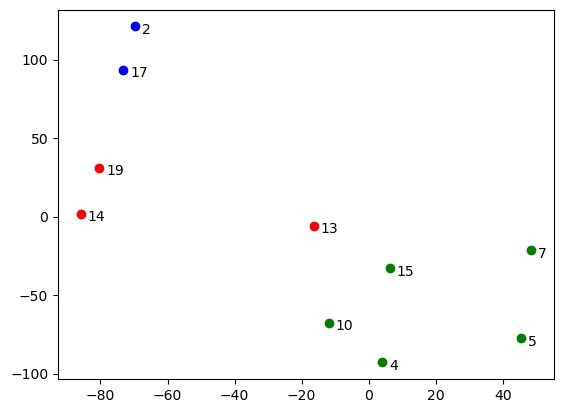

In [21]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Получаем матрицу тематик
topics = lda.show_topics(num_topics=10, num_words=10, formatted=False)

# Составляем матрицу признаков для кластеризации
X = np.zeros((len(topics), len(topics[0][1])))
for i, (topic_id, words) in enumerate(topics):
    for j, (word, prob) in enumerate(words):
        X[i,j] = prob

# Кластеризуем тематики
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Визуализируем результаты с помощью метода t-SNE
tsne = TSNE(n_components=2, perplexity=3, learning_rate=100, n_iter=1000, random_state=0)
X_tsne = tsne.fit_transform(X)

# Рисуем график
colors = ['red', 'green', 'blue']
for i, (topic_id, words) in enumerate(topics):
    plt.scatter(X_tsne[i,0], X_tsne[i,1], color=colors[kmeans.labels_[i]])
    plt.annotate(topic_id, xy=(X_tsne[i,0], X_tsne[i,1]), xytext=(5,-5), textcoords='offset points')
plt.show()
